Classificação
=================



## Classificação supervisionada via aprendizado de máquina



Até agora vocês aplicaram modelos de regressão supervisionados. Ou seja, vocês forneceram um banco de dados e escolheram uma variável alvo, com o modelo de regressão vocês puderam obter valores próximos, ou nem tanto, dos valores alvo.

Agora, vocês irão aprender outro uso do aprendizado de máquina, a classificação. Com ela, podemos separar os dados em diferentes grupos ou entidades, então treinar nosso modelo para classificar nossos objetos, que já terão suas classes definidas préviamente. Isso é equivalente a regressão que já tina seus valores definidos, porém agora o que está definido são as classes.

A classificação pode ser entendida de maneira simples com seu uso para imagens. Na imagem abaixo temos imagens de gatos e cachorros, um bom algoritmo de classificação poderá identificar corretamente quais imagens são de gatos e quais são de cachorros. Num algoritmo supervisionado, são fornecidas varias imagens já com a espécie do animal definida, assim, se o número de imagens for suficiente, o algoritmo será bem treinado.

<img src="https://blogs.sas.com/content/subconsciousmusings/files/2017/09/cat-dog-1024x521.png" alt="Imagem de gatos e cachorros" style="width: 500px;"/>
Fonte: https://blogs.sas.com/content/subconsciousmusings/2017/09/25/machine-learning-concepts-styles-machine-learning/

Note que, o algoritmo estará muito bem treinado para os dados fornecidos, porém, se você fornecer a imagem de um golfinho, ele a identificará como gato ou cachorro, porque o conhecimento do modelo é apenas este. Assim como, se você treinar um modelo para reconhecer números, ao fornecer uma letra ou qualquer outra imagem, ele atribuirá um número para ela. Portanto, cuidado ao extrapolar seus modelos, tenham em mente o domínio de dados para o qual o modelo foi treinado.

Neste Notebook iremos aplicar os modelos de classificação baseados em $k$-NN, arvores de decisão e florestas aleatórias, ou seja, os mesmos modelos que vocês já utilizaram para regressão. Como de costume, recomendamos o vídeo do [StatQuest](https://www.youtube.com/watch?v=_L39rN6gz7Y) para aprender um pouco mais sobre o assunto. A fundamentação teórica dos métodos é a mesma, porém agora não iremos prever valores numéricos mas sim grupos ou classes.

## Qual será nosso alvo?

Nos últimos Notebooks utilizamos o dataset de preços de diamantes do Seaborn, portanto vamos continuar utilizando ele. No entanto, nosso alvo sempre foi o preço dos diamentes, que é um valor numérico. Agora queremos classificar em grupos, portanto o preço numérico não é útil para isso...
No entanto, podemos utilizar um truque para utilizar a classificação. Vamos agrupar os preços dos diamantes em:

- Muito caro
- Caro
- Médio
- Barato
- Muito barato

Para escolhermos as faixas de valores é importante analisar a distribuição de preços:
Vamos carregar os dados:

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

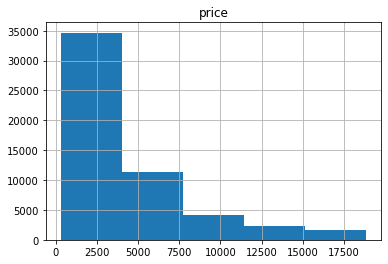

In [3]:
import seaborn as sns
import pandas as pd

DATASET_NAME = "diamonds"
df = sns.load_dataset(DATASET_NAME)
TARGET = ["price"]
df[TARGET].hist(bins=5)


Podemos notar que dividir nossos preços em cinco faixas de valores igual não é uma boa estratégia, porque?
Porque temos muito mais diamantes muito baratos do que os caros e muito caros. Isso levará a uma performance ruim do modelo para classificar os muito caros.
Vamos observar um histograma com uma melhor resolução:

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

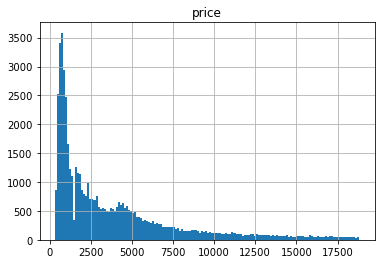

In [4]:
df[TARGET].hist(bins=150)


Nossos dados estão concentrados no diamantes mais baratos. Tudo bem, vamos tentar distribuir nossos grupos de preço de uma maneira que divida razoávelmente nossos preços:

In [5]:
logic = df["price"] <= 1000
print(len(df.loc[logic]),'Diamantes muito baratos')
logic = (df["price"] > 1000) & (df["price"] <= 2500)
print(len(df.loc[logic]),'Diamantes baratos')
logic = (df["price"] > 2500) & (df["price"] <= 5000)
print(len(df.loc[logic]),'Diamantes de preço médio')
logic = (df["price"] > 5000) & (df["price"] <= 8000)
print(len(df.loc[logic]),'Diamantes caros')
logic = (df["price"] > 8000)
print(len(df.loc[logic]),'Diamantes muito caros')

14524 Diamantes muito baratos
13018 Diamantes baratos
11684 Diamantes de preço médio
7109 Diamantes caros
7605 Diamantes muito caros


Agora temos algo razoável do ponto de vista de dados. Porém, quem entende de diamantes pode argumentar que essas faixas de valores não são as melhores, que o muito caros teriam que ser acima de 15000 mil dólares ou algo do tipo. No entando, aqui estamos pensando do ponto de vista de divisão dos dados apenas.

Fique a vontade para mudar as faixas de valores como preferir.

Vamos criar uma nova coluna com as categorias de preços então:

In [6]:
df['Preço Categórico'] = None

logic = df["price"] <= 1000
df.loc[logic, 'Preço Categórico'] = 'Muito Barato'
logic = (df["price"] > 1000) & (df["price"] <= 2500)
df.loc[logic, 'Preço Categórico'] = 'Barato'
logic = (df["price"] > 2500) & (df["price"] <= 5000)
df.loc[logic, 'Preço Categórico'] = 'Médio'
logic = (df["price"] > 5000) & (df["price"] <= 8000)
df.loc[logic, 'Preço Categórico'] = 'Caro'
logic = (df["price"] > 8000)
df.loc[logic, 'Preço Categórico'] = 'Muito Caro'
print(df)


       carat        cut color clarity  depth  table  price     x     y     z  \
0       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43   
1       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
2       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...   
53935   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50   
53936   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61   
53937   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56   
53938   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74   
53939   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64   

      Preço Categórico  
0         Muit

Ótimo! Agora criamos nossa nova coluna com preços categóricos, estamos prontos para realizar nosso aprendizado de máquina de classificação.

## Classificação com $k$-NN


A maneira de criar um $k$-NN classificador é muito semelhante ao que vimos para um $k$-NN regressor.
Já temos nosso dataset no DataFrame df, então vamos apenas definir o necessário para o classificador:

In [7]:
import seaborn as sns
from sklearn.model_selection import train_test_split

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
FEATURES = ["carat", "depth", "table", "x", "y", "z"]
TARGET = ["Preço Categórico"]

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel()
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel()

Agora vamos treinar nosso modelo classificador:

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# cria o modelo
modelo_knn = KNeighborsClassifier()

# treina o modelo
modelo_knn.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_knn.predict(X_teste)
print(previsao)

['Barato' 'Muito Barato' 'Muito Barato' ... 'Muito Barato' 'Muito Barato'
 'Barato']


Perfeito, modelo treinado!
Agora vamos testar sua performance, mas, como vou calcular o RMSE para dados categóricos? A resposta direta é não é possível, a não ser que você atribua valores a cada categoria... Mas há outras maneiras de avaliarmos o modelo, o próprio ScikitLearn tem uma classe chamada metrics, para avaliarmos modelos. 
Vamos utilizar a função accuracy_score, que avalia quantas vezes o modelo acertou a categoria de preço. Consulte a documentação dessa função aqui: [Read The Docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)


In [9]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_teste, previsao))

Accuracy: 0.7554690396737115


Temos uma acurácia de 75.5%, algo razoável, consideravelmente melhor que jogar um dado de cinco lados para determinar a categoria de preço. Lembre que não mudamos nada nos hiperparâmetros do modelo, fica como dica para vocês explorarem.

## Classificação com Árvore de Decisão

Novamente, a maneira de fazermos a classificação é muito semelhante a regressão. Façamos isso então:

In [10]:
from sklearn.tree import DecisionTreeClassifier

# cria o modelo
modelo_dt = DecisionTreeClassifier(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_dt.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(X_teste)
print(previsao)

['Barato' 'Muito Barato' 'Barato' ... 'Muito Barato' 'Muito Barato'
 'Muito Barato']


Vamos checar a performance do nosso modelo de árvore de decisão.



In [11]:
print("Accuracy:",metrics.accuracy_score(y_teste, previsao))


Accuracy: 0.7046718576195773


Tivemos uma acurácia inferior ao modelo $k$-NN. Porém, novamente não modificamos nenhum hiperparâmetro, e já sabemos o quão importante eles são para árvores de decisão.
Lembrem que vocês também podem converter dados ordinais em dados númericos, como descrito na última aula. Assim vocês poderão utilizar as features 'cut' e 'clarity', ou com um *one-hot encoder*, utilizar a cor do diamente.

## Classificação com Florestas Aleatórias

Agora vamos ao modelo de florestas aleatórias, que para a regressão já se mostrou um modelo muito bom.
Novamente o processo é muito semelhante ao regressor, então vamos lá:


In [12]:
from sklearn.ensemble import RandomForestClassifier

# cria o modelo
modelo_rf = RandomForestClassifier(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_rf.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_rf.predict(X_teste)
print(previsao)

['Barato' 'Muito Barato' 'Muito Barato' ... 'Muito Barato' 'Muito Barato'
 'Muito Barato']


Vamos testar a acurácia do modelo de floresta aleatória:

In [13]:
print("Accuracy:",metrics.accuracy_score(y_teste, previsao))


Accuracy: 0.7615869484612533


Tivemos uma acurácia superior ao modelo $k$-NN, sendo a melhor dos três modelos. Novamente não modificamos nenhum hiperparâmetro, sabendo que eles são bastante importes para florestas aleatórias. Portanto, tente melhorar este modelo modificando seus hiperparâmetros.

## Extra, avaliando hiperparâmetros automaticamente:

Uma função bastante útil do ScikitLearn é a GridSearchCV, que a busca por hiperparâmetros de maneira automática, basta passar para ele quais parâmetros você deseja avaliar que ele combina todos! Notem que o número de combinações pode ser grande, então isso pode levar bastante tempo para ser executado.

Consulte a [documentação do GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para mais informações. Notem que ele usa validação cruzada, um conceito ainda não apresentado para vocês. Para aprender mais sobre validação cruzada, vale assistir o vídeo do [StatQuest](https://www.youtube.com/watch?v=fSytzGwwBVw) sobre o assunto.

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [200, 300, 400, 500, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10,12,14,16],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=modelo_rf, param_grid=param_grid, cv= 5, n_jobs=8)
CV_rfc.fit(X_treino, y_treino)

/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=61455),
             n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14, 16],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500, 600]})

Otimização feita, vamos extrair quais foram os melhores hiperparâmetros:

In [16]:
print(CV_rfc.best_params_)
best_params = CV_rfc.best_params_

{'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'n_estimators': 600}


Os melhores parâmetros foram mostrados acima. Notamos que o *n_estimators* ficou no valor máximo que escolhemos, talvez algum valor maior seja melhor.

Outra observação é que nas versões mais novas do ScikitLearn, o hiperparâmetro *'max_features' = 'auto'* está depreciado, na verdade ele aponta para o *'sqrt'*. Portanto, vamos renomeá-lo para *'max_features' = 'sqrt'*.

Vamos treinar nosso modelo com os melhores parâmetros obtidos então:

In [17]:
best_params = {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 600}

In [18]:
modelo_rf = RandomForestClassifier(random_state=SEMENTE_ALEATORIA)
modelo_rf.set_params(**best_params)


RandomForestClassifier(criterion='entropy', max_depth=14, max_features='sqrt',
                       n_estimators=600, random_state=61455)

In [19]:
modelo_rf.fit(X_treino, y_treino)
previsao = modelo_rf.predict(X_teste)
print(previsao)
print("Accuracy:",metrics.accuracy_score(y_teste, previsao))


['Muito Barato' 'Muito Barato' 'Muito Barato' ... 'Muito Barato'
 'Muito Barato' 'Muito Barato']
Accuracy: 0.7769744160177976


Modelo treinado! A acurácia foi de 77.7%, melhorou um pouco frente aos valores padrão, mas não muito. Pode ser que seja mais importante converter as features categóricas ordinais para utilizar no nosso modelo. Esta fica como tarfa para vocês :)